# Data access

In [1]:
import random 

def random_sample_from_list(choices, k=1):
    return random.sample(choices, k=k)

DFLT_HEALTHY = ['Healthy_0', 'Healthy_1','Healthy_2']
DFLT_UNHEALTHY=['Failure', 'Imbalance', 'Defect', 'Noise']

def random_int():
    return random.randint(0, 1)
    
def mock_annotations():
    choice = random_int()
    if choice == 0:
        return random_sample_from_list(DFLT_HEALTHY, k=random.randint(1, len(DFLT_HEALTHY)))
    else:
        return random_sample_from_list(DFLT_UNHEALTHY, k=random.randint(1, len(DFLT_HEALTHY)))

    

In [2]:
mock_annotations()

['Healthy_0', 'Healthy_2']

In [3]:
import pandas as pd
from typing import List, Dict

def mock_session_gen(n: int = 10) -> List[Dict]:
    sessions = []
    time_step = 600000000
    sample_rates = [44100, 48000]

    for i in range(n):
        bt = 1677672000000000 + (i * time_step)
        tt = 1677672000000000 + ((i + 1) * time_step)

        
        sessions.append(
            {
                'ID': f'mockSession{i}',
                'device_id': f'deviceId{i % 2 + 1}',
                'bt': bt,
                'tt': tt,
                'sr': sample_rates[i % 2],
                #'bit_depth': 8,
                #'channels': channels,
                'annotations': mock_annotations(),
            }
        )

    return sessions

In [4]:
mock_session_gen(3)

[{'ID': 'mockSession0',
  'device_id': 'deviceId1',
  'bt': 1677672000000000,
  'tt': 1677672600000000,
  'sr': 44100,
  'annotations': ['Defect', 'Imbalance', 'Noise']},
 {'ID': 'mockSession1',
  'device_id': 'deviceId2',
  'bt': 1677672600000000,
  'tt': 1677673200000000,
  'sr': 48000,
  'annotations': ['Healthy_0', 'Healthy_1', 'Healthy_2']},
 {'ID': 'mockSession2',
  'device_id': 'deviceId1',
  'bt': 1677673200000000,
  'tt': 1677673800000000,
  'sr': 44100,
  'annotations': ['Healthy_2', 'Healthy_1', 'Healthy_0']}]

In [5]:
def mk_dataset(n: int = 10) -> pd.DataFrame:
    df = pd.DataFrame(mock_session_gen(n))
    return df

df = mk_dataset(10)
df

,ID,device_id,bt,tt,sr,annotations
0,mockSession0,deviceId1,1677672000000000,1677672600000000,44100,"[Failure, Noise, Imbalance]"
1,mockSession1,deviceId2,1677672600000000,1677673200000000,48000,[Defect]
2,mockSession2,deviceId1,1677673200000000,1677673800000000,44100,"[Imbalance, Noise]"
3,mockSession3,deviceId2,1677673800000000,1677674400000000,48000,"[Healthy_2, Healthy_1, Healthy_0]"
4,mockSession4,deviceId1,1677674400000000,1677675000000000,44100,"[Healthy_2, Healthy_0]"
5,mockSession5,deviceId2,1677675000000000,1677675600000000,48000,[Healthy_0]
6,mockSession6,deviceId1,1677675600000000,1677676200000000,44100,"[Healthy_0, Healthy_2, Healthy_1]"
7,mockSession7,deviceId2,1677676200000000,1677676800000000,48000,"[Healthy_0, Healthy_1, Healthy_2]"
8,mockSession8,deviceId1,1677676800000000,1677677400000000,44100,"[Noise, Imbalance]"
9,mockSession9,deviceId2,1677677400000000,1677678000000000,48000,"[Healthy_2, Healthy_1, Healthy_0]"


# Funcs for the dag

### [Charlie's DAGs] DPP Builder for MVP

#### With kfold partitioning

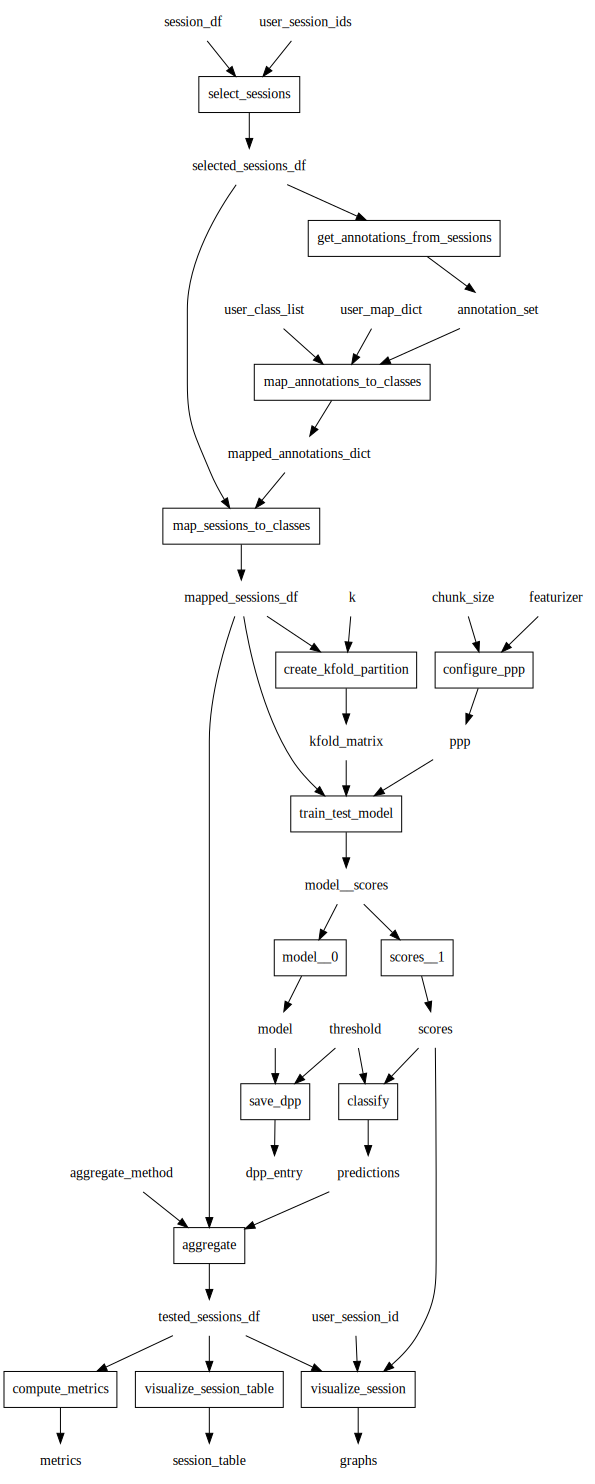

In [6]:
from meshed import code_to_dag

@code_to_dag
def kfold_dpp_builder():
    # SELECT DATASET (remove sessions from db that are not relevant to model training/testing)
    selected_sessions_df = select_sessions(session_df, user_session_ids)  
    # user_session_ids is the list of ids of the sessions selected by the users in the UI

    # MAP ANNOTATIONS TO CLASSES
    annotation_set = get_annotations_from_sessions(selected_sessions_df)
    mapped_annotations_dict = map_annotations_to_classes(annotation_set, user_class_list, user_map_dict)
    # The function map_annotations_to_classes verifies each class is mapped to at least one annotation
    # and that each annotation is mapped to one class at max
    # user_class_list is the list of classes created by the users in the UI (by defining the number and names of classes)
    # user_map_dict is the mapping done by the user in the UI

    # MAP CLASSES TO SESSIONS, AND CREATE CROSS-VALIDATION PARTITIONS (KFOLD)
    mapped_sessions_df = map_sessions_to_classes(selected_sessions_df, mapped_annotations_dict) 
    # mapped_sessions_df is the same as selected_sessions_df with an additional "Class" attribute
    kfold_matrix = create_kfold_partition(mapped_sessions_df, k) 
    # k is the number of partitions to be created
    # kfold_matrix is filled with 1s and 0s. Number of rows is number of sessions; number of columns is number of partitions

    # TRAIN & TEST
    ppp = configure_ppp(chunk_size, featurizer)
    model, scores = train_test_model(mapped_sessions_df, ppp, kfold_matrix)
    # model contains the ppp and model parameters
    # scores is a list of list, containing the chunk scores for each session
    
    # CLASSIFY AND AGGREGATE
    predictions = classify(scores, threshold)
    # predictions is a list of list, containing the chunk predictions for each session
    tested_sessions_df = aggregate(mapped_sessions_df, predictions, aggregate_method)
    # tested_sessions_df is the same as mapped_sessions_df with additional "Class predicted" and "Prediction accuracy" attributes

    # VISUALIZE RESULTS
    session_table = visualize_session_table(tested_sessions_df)
    metrics = compute_metrics(tested_sessions_df)
    graphs = visualize_session(tested_sessions_df, scores, user_session_id)   

    # Tune & Save
    dpp_entry = save_dpp(model, threshold)

kfold_dpp_builder.dot_digraph()

#### With hold-out partitioning (single train / test)

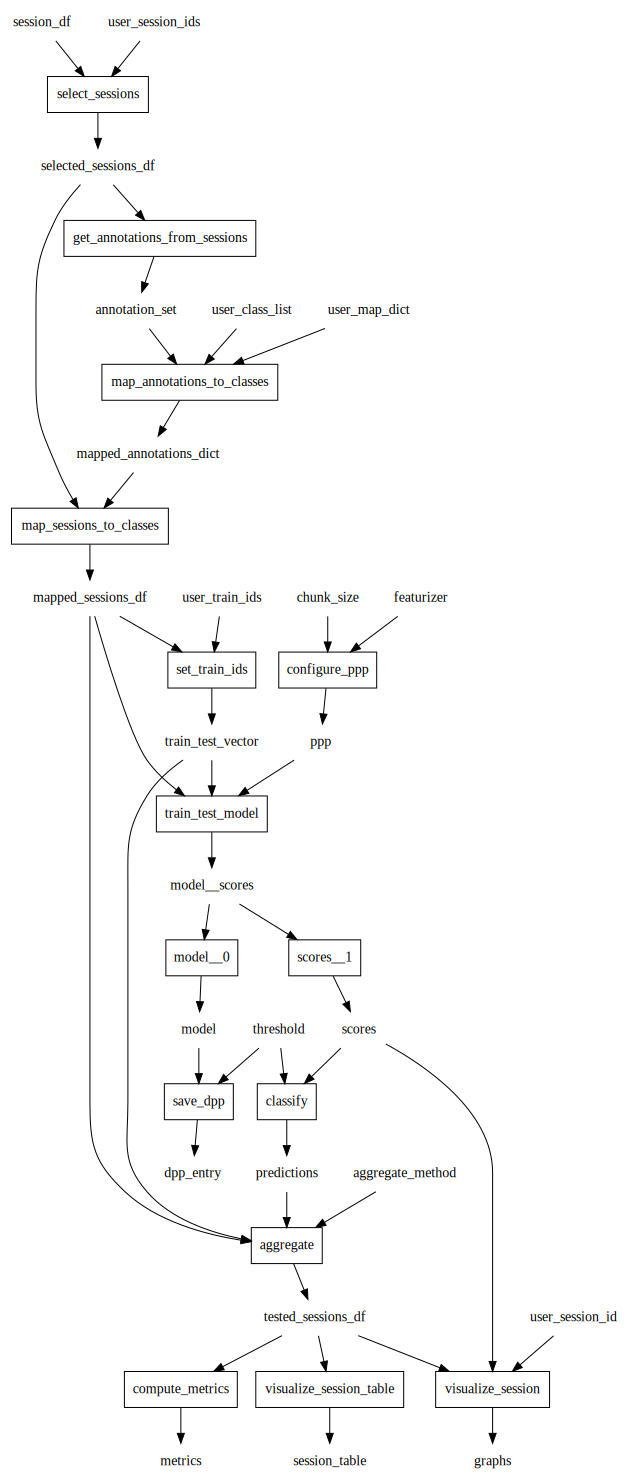

In [7]:
from meshed import code_to_dag

@code_to_dag
def holdout_dpp_builder():
    # SELECT DATASET (remove sessions from db that are not relevant to model training/testing)
    selected_sessions_df = select_sessions(session_df, user_session_ids)  
    # user_session_ids is the list of ids of the sessions selected by the users in the UI

    # MAP ANNOTATIONS TO CLASSES
    annotation_set = get_annotations_from_sessions(selected_sessions_df)
    mapped_annotations_dict = map_annotations_to_classes(annotation_set, user_class_list, user_map_dict)
    # The function map_annotations_to_classes verifies each class is mapped to at least one annotation
    # and that each annotation is mapped to one class at max
    # user_class_list is the list of classes created by the users in the UI (by defining the number and names of classes)
    # user_map_dict is the mapping done by the user in the UI

    # MAP CLASSES TO SESSIONS, AND CREATE CROSS-VALIDATION PARTITION (HOLD-OUT: SINGLE TRAIN/TEST)
    mapped_sessions_df = map_sessions_to_classes(selected_sessions_df, mapped_annotations_dict) 
    # mapped_sessions_df is the same as selected_sessions_df with an additional "Class" attribute
    train_test_vector = set_train_ids(mapped_sessions_df, user_train_ids) 
    # The function set_train_ids verifies the sessions selected are all of class "normal"
    # user_train_ids is the list of sessions selected by the user for training
    # train_test_vector is filled with 1s and 0s. Number of elements is number of sessions

    # TRAIN & TEST
    ppp = configure_ppp(chunk_size, featurizer)
    model, scores = train_test_model(mapped_sessions_df, ppp, train_test_vector)
    # model contains the ppp and model parameters
    # scores is a list of list, containing the chunk scores for each tested session
    
    # CLASSIFY AND AGGREGATE
    predictions = classify(scores, threshold)
    # predictions is a list of list, containing the chunk predictions for each tested session
    tested_sessions_df = aggregate(mapped_sessions_df, train_test_vector, predictions, aggregate_method)
    # tested_sessions_df has the same attributes as mapped_sessions_df plus "Class predicted" and "Prediction accuracy"
    # Note that tested_sessions_df has fewer entries than the original dataset. It only contains the sessions that have been tested  

    # VISUALIZE RESULTS
    session_table = visualize_session_table(tested_sessions_df)
    metrics = compute_metrics(tested_sessions_df)
    graphs = visualize_session(tested_sessions_df, scores, user_session_id)   

    # Tune & Save
    dpp_entry = save_dpp(model, threshold)

holdout_dpp_builder.dot_digraph()

In [8]:
def select_sessions(session_df, session_ids):
    return session_df[session_df['ID'].isin(session_ids)]



In [9]:
# Session selection and visualization
def identity(x):
    return x

selected_IDs = [f'mockSession{i}' for i in range(10)]

selected_sessions = select_sessions(df, selected_IDs)
selected_sessions

,ID,device_id,bt,tt,sr,annotations
0,mockSession0,deviceId1,1677672000000000,1677672600000000,44100,"[Failure, Noise, Imbalance]"
1,mockSession1,deviceId2,1677672600000000,1677673200000000,48000,[Defect]
2,mockSession2,deviceId1,1677673200000000,1677673800000000,44100,"[Imbalance, Noise]"
3,mockSession3,deviceId2,1677673800000000,1677674400000000,48000,"[Healthy_2, Healthy_1, Healthy_0]"
4,mockSession4,deviceId1,1677674400000000,1677675000000000,44100,"[Healthy_2, Healthy_0]"
5,mockSession5,deviceId2,1677675000000000,1677675600000000,48000,[Healthy_0]
6,mockSession6,deviceId1,1677675600000000,1677676200000000,44100,"[Healthy_0, Healthy_2, Healthy_1]"
7,mockSession7,deviceId2,1677676200000000,1677676800000000,48000,"[Healthy_0, Healthy_1, Healthy_2]"
8,mockSession8,deviceId1,1677676800000000,1677677400000000,44100,"[Noise, Imbalance]"
9,mockSession9,deviceId2,1677677400000000,1677678000000000,48000,"[Healthy_2, Healthy_1, Healthy_0]"


In [10]:

def get_annotations_from_sessions(session_df):
    return set.union(*session_df['annotations'].apply(set))

In [11]:
annotation_set = get_annotations_from_sessions(df)
annotation_set

{'Defect',
 'Failure',
 'Healthy_0',
 'Healthy_1',
 'Healthy_2',
 'Imbalance',
 'Noise'}

In [12]:
# check 'normal' is assigned to at least one annotation
map_table = {'Healthy_0': 'Normal', 'Healthy_1': 'Normal', 'Healthy_2': 'Normal', 'Failure': 'Outlier', 'Imbalance': 'Outlier', 'Defect': 'Outlier', 'Noise': 'Outlier'}


def map_annotations_to_classes(map_table):
    # add verifications
    def mapper(annotation_set):
        return next(iter({map_table[item] for item in annotation_set}))
    return mapper

def map_sessions_to_classes(selected_sessions, map_table):
    mapper = map_annotations_to_classes(map_table)
    df = selected_sessions.copy()
    classes = df['annotations'].apply(lambda x:  mapper(set(x)))
    df['class']=classes
    return df


In [13]:
mapped_sessions = map_sessions_to_classes(selected_sessions, map_table)
mapped_sessions

,ID,device_id,bt,tt,sr,annotations,class
0,mockSession0,deviceId1,1677672000000000,1677672600000000,44100,"[Failure, Noise, Imbalance]",Outlier
1,mockSession1,deviceId2,1677672600000000,1677673200000000,48000,[Defect],Outlier
2,mockSession2,deviceId1,1677673200000000,1677673800000000,44100,"[Imbalance, Noise]",Outlier
3,mockSession3,deviceId2,1677673800000000,1677674400000000,48000,"[Healthy_2, Healthy_1, Healthy_0]",Normal
4,mockSession4,deviceId1,1677674400000000,1677675000000000,44100,"[Healthy_2, Healthy_0]",Normal
5,mockSession5,deviceId2,1677675000000000,1677675600000000,48000,[Healthy_0],Normal
6,mockSession6,deviceId1,1677675600000000,1677676200000000,44100,"[Healthy_0, Healthy_2, Healthy_1]",Normal
7,mockSession7,deviceId2,1677676200000000,1677676800000000,48000,"[Healthy_0, Healthy_1, Healthy_2]",Normal
8,mockSession8,deviceId1,1677676800000000,1677677400000000,44100,"[Noise, Imbalance]",Outlier
9,mockSession9,deviceId2,1677677400000000,1677678000000000,48000,"[Healthy_2, Healthy_1, Healthy_0]",Normal


In [14]:
from olab.base import simple_chunker, simple_featurizer
from functools import partial, reduce

def compose2(f,g):
    def composition(x):
        return f(g(x))
    return composition

def configure_ppp(chk_size, featurizer=simple_featurizer):
    funcs = [featurizer, partial(simple_chunker, chk_size=chk_size)]
    return compose2(*funcs)

/Users/sylvain/opt/anaconda3/envs/otopy310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
configure_ppp(256)

<function __main__.compose2.<locals>.composition(x)>

In [16]:
list('Hfgg')[::]

['H', 'f', 'g', 'g']

In [20]:
import numpy as np

from sklearn.model_selection import KFold


DFLT_FILTER=lambda x:x.lower()=='normal'

def create_kfold_matrix(X, n_splits=3, filter_func=DFLT_FILTER):
    from sklearn.model_selection import KFold 
    normal_tags_idx = np.array([i for i,item in enumerate(X) if filter_func(item)])

    kf = KFold(n_splits=n_splits)
    y = normal_tags_idx[::]
    n_samples = len(y)
    x_rows = np.zeros(n_samples)
    splits = kf.split(x_rows, y)
    split_matrix = np.zeros(shape=(len(X),n_splits))
    for i,split in enumerate(splits):
        train_idx, test_idx = split
        split_matrix[normal_tags_idx[train_idx],i]=1
        
    
    return split_matrix

def create_kfold_matrix_from_dataset(dataset, n_splits=3, filter_func=DFLT_FILTER):
    X = dataset['class']
    return create_kfold_matrix(X, n_splits, filter_func)

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def dataset_train_test_split(dataset, pipeline_model, split_matrix):
    pipeline, model = pipeline_model
    _, n_splits = split_matrix.shape
    session_ids = dataset['session_ids']
    scores = []
    for split in range(n_splits):
        train_ids_for_split = [session_id for i,session_id in enumerate(session_ids) if split_matrix[i,split]>0]
        test_ids_for_split = [session_id for i,session_id in enumerate(session_ids) if split_matrix[i,split]==0]

        train_fvs = [pipeline(fetch_session_data(session_id)) for session_id in train_ids_for_split]
        test_fvs = [pipeline(fetch_session_data(session_id)) for session_id in test_ids_for_split]

        fitted_model = model().fit(flatten(train_fvs))
        scores_for_split = [fitted_model.score_samples(row) for row in test_fvs]
        res.append(scores_for_split)
        
    return res
        
def k_fold_scores(dataset, pipeline_model, n_splits=3, fetch_session_data=None, filter_func=DFLT_FILTER):
    split_matrix = create_kfold_matrix_from_dataset(dataset, n_splits, filter_func)
    scores = dataset_train_test_split(dataset, pipeline_model, split_matrix)
    
    return scores 
        

In [23]:
mapped_sessions.head()

,ID,device_id,bt,tt,sr,annotations,class
0,mockSession0,deviceId1,1677672000000000,1677672600000000,44100,"[Failure, Noise, Imbalance]",Outlier
1,mockSession1,deviceId2,1677672600000000,1677673200000000,48000,[Defect],Outlier
2,mockSession2,deviceId1,1677673200000000,1677673800000000,44100,"[Imbalance, Noise]",Outlier
3,mockSession3,deviceId2,1677673800000000,1677674400000000,48000,"[Healthy_2, Healthy_1, Healthy_0]",Normal
4,mockSession4,deviceId1,1677674400000000,1677675000000000,44100,"[Healthy_2, Healthy_0]",Normal


In [21]:
create_kfold_matrix_from_dataset(mapped_sessions)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 1.],
       [0., 1., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 1., 0.],
       [0., 0., 0.],
       [1., 1., 0.]])

In [46]:
flatten([[1,2,3],[4,5]])

[1, 2, 3, 4, 5]

In [43]:
tags=['normal', 'ab', 'normal','normal']
list(create_kfold_partition(tags))

[array([0., 1., 1.]),
 array([0., 0., 0.]),
 array([1., 0., 1.]),
 array([1., 1., 0.])]

In [40]:
list(map(DFLT_FILTER,tags))

[True, False, True, True]

In [41]:
arr = np.array(tags)
arr[arr=='normal']

array(['normal', 'normal', 'normal'], dtype='<U6')

In [16]:
# create list of splits (train_idx, test_idx)
list(create_kfold_partition(mapped_sessions))[:3]

/Users/sylvain/opt/anaconda3/envs/otopy310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/sylvain/opt/anaconda3/envs/otopy310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[(array([4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3])),
 (array([0, 1, 2, 3, 7, 8, 9]), array([4, 5, 6])),
 (array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9]))]

In [ ]:
# WIP 
def train_test_model(mapped_sessions, pipeline, kfold_partition):
    for train, test in kfold_partition:
        train_df = mapped_sessions.iloc[train]
        test_df = mapped_sessions.iloc[test]
        X_train = train_df['data'].values
        y_train = train_df['class'].values
        X_test = test_df['data'].values
        y_test = test_df['class'].values
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_df['y_pred'] = y_pred
        yield test_df

    

# Scrap

In [1]:
from typing import Literal


def get_data(type: Literal['training', 'testing'], nb_files: int):
    path_base = '/Users/vferon/otosense/data/DrillDataset/'
    path_suffix = 'Normal/normal' if type == 'training' else 'Anomaly/fault'
    
    for i in range(nb_files):
        with open(f'{path_base}{path_suffix}_{i+1}.wav', 'rb') as f:
            yield f.read()


# training_data = list(get_data('training', 10))
# testing_data = list(get_data('testing', 10))

ff


In [86]:
from odat.mdat import vacuum as vm

In [87]:
dacc = vm.mk_dacc()

In [88]:
dir(dacc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'annots_df',
 'chk_tag_train_gen',
 'fvs_tag_train_gen',
 'mk_Xy',
 'mk_annots',
 'wf_tag_train_gen',
 'wfs']

In [91]:
annots = dacc.mk_annots()
annots

[('test/vacuum.VacuumCleaner_8.11.1760000-1920000.wav.23q8f9cb.ingestion-6bc8b65f8c-86d4w.wav',
  'vacuum',
  'test',
  'VacuumCleaner_8'),
 ('test/vacuum.VacuumCleaner_8.2.320000-480000.wav.23q8f9b7.ingestion-6bc8b65f8c-vrv59.wav',
  'vacuum',
  'test',
  'VacuumCleaner_8'),
 ('test/noise.Babble_7.30.4800000-4960000.wav.23q8f8pc.ingestion-6bc8b65f8c-86d4w.wav',
  'noise',
  'test',
  'Babble_7'),
 ('test/noise.DWASHING.18.2880000-3040000.wav.23q8f9bu.ingestion-6bc8b65f8c-cfffs.wav',
  'noise',
  'test',
  'DWASHING'),
 ('test/vacuum.VacuumCleaner_8.5.800000-960000.wav.23q8f9b4.ingestion-6bc8b65f8c-cfffs.wav',
  'vacuum',
  'test',
  'VacuumCleaner_8'),
 ('test/vacuum.VacuumCleaner_1.0.0-160000.wav.23q8f9ah.ingestion-6bc8b65f8c-vrv59.wav',
  'vacuum',
  'test',
  'VacuumCleaner_1'),
 ('test/noise.DLIVING.34.5440000-5600000.wav.23q8f97h.ingestion-6bc8b65f8c-vrv59.wav',
  'noise',
  'test',
  'DLIVING'),
 ('test/vacuum.VacuumCleaner_3.0.0-160000.wav.23q8f9bm.ingestion-6bc8b65f8c-86d4w.wa

In [93]:
set(annot[-1] for annot in annots)

{'AirConditioner_10',
 'AirConditioner_2',
 'AirConditioner_7',
 'AirConditioner_9',
 'Babble_1',
 'Babble_10',
 'Babble_2',
 'Babble_4',
 'Babble_5',
 'Babble_6',
 'Babble_7',
 'Babble_9',
 'DKITCHEN',
 'DLIVING',
 'DWASHING',
 'VacuumCleaner_1',
 'VacuumCleaner_2',
 'VacuumCleaner_3',
 'VacuumCleaner_5',
 'VacuumCleaner_6',
 'VacuumCleaner_7',
 'VacuumCleaner_8',
 'VacuumCleaner_9'}